In [1]:
from chainer import links as L
import chainer.functions as F
import chainer
from chainer import Chain, Link
from chainer import Parameter
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from chainer import Variable, optimizers
import numpy as np
import PIL.Image
from io import BytesIO

mean = [103.939, 116.779, 123.68]   # BGR
#  modelVGG = VGG16Layers()

from IPython.display import clear_output, Image, display
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# 基本入出力関数

# 配列の表示
def showarray(a, fmt='jpeg'):  # numpy 配列としての画像を表示
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# blob データを PIL 画像に変換
def blob2img(blob, mean=mean):
    blob = (np.dstack(blob)+ mean)[:,:,::-1]   # BGR 2 RGB
    return PIL.Image.fromarray(np.uint8(blob))

# blob データを画像として保存
def save_image(blobimg, it):
    def clip(a):
        return 0 if a<0 else (255 if a>255 else a)
    blobimg = np.vectorize(clip)(blobimg)
    image = blob2img(blobimg)
    image.save("frames/im_%05d.png"%it)
    return image

# チャネル間の相関行列
def ch_corr_matrix(ld):
    # 0次元目はバッチ数
    ch = ld.shape[1] # チャネル数
    size = ld[0][0].size  # チャネルあたりのデータ数
    cmatrix = F.reshape(ld, (ch,size)) # チャネルごとに１次元化した ch x size の配列を作る
    matrix = F.matmul(cmatrix, cmatrix,transb=True) / np.float32(ch*size) # 相関行列
    return matrix

In [3]:
# layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "pool4"]
# layers_for_style =["conv1_1", "conv1_2", "pool1", "conv2_1", "conv2_2", "pool2", "conv3_1", "conv3_2", "conv3_3v3","pool3"]

lr = np.float32(400.0) # 学習係数
rr = np.float32(0.005) # 元画像/スタイル画像 比率
width = 224
CROPSIZE = (3,224,224)
iter = 5000  # 繰り返し回数

class MyVGG(VGG16Layers):
    def __init__(self):
        super(MyVGG, self).__init__()
        with self.init_scope():
            self.autopic = chainer.links.Parameter(self.genpic())
            self.opic = np.zeros(CROPSIZE ,dtype='f')
            self.spic = np.zeros(CROPSIZE ,dtype='f')
    
    def __call__(self, vimg, layers=['prob']):
         return self.myextract(vimg, layers=layers)
            
    def myextract(self,vimg, layers=['prob']):
        if vimg.data.ndim == 3:
            vimg = F.reshape(vimg,(1,3,224,224))
        return super(MyVGG,self).__call__(vimg,layers=layers)
    
    def genpic(self):
        genpic = np.random.uniform(-20,20,CROPSIZE ).astype(np.float32)
        return genpic
    
    def setpic(self, nimg):
        self.autopic.W.data = nimg
 
    def show(self,mode=0):
        if mode == 1 :
           img = blob2img(self.opic)
        elif mode == 2 :
           img = blob2img(self.spic)
        else :
           img = blob2img(self.autopic.data)  
        return img
        
    # ファイルから画像を生成
    def setImage(self,filename):
        img = PIL.Image.open(filename)
        nimg = VGGprepare(img)
        return nimg

    # autopic をもとに前向き伝搬
    def autoforward(self,layers=['prob']):
        h = self.myextract(self.autopic, layers=layers)
        return h
    
    # 処理対象画像をセット
    def setOimage(self,fname, layers=['vpool4']):
        print('Original image set',fname)
        self.opic =  self.setImage(fname)
        vimg = Variable(self.opic)
        h = self.myextract(vimg,layers=layers)
        self.Ofeatures = h

    # スタイル画像をセット
    def setSimage(self,fname, layers=['conv4_1']):
        print('Style image set',fname)
        self.spic =  self.setImage(fname)
        vimg = Variable(self.spic)
        h = self.myextract(vimg,layers=layers)
        cor = {}
        for l in h.keys():
            cor.update({l:ch_corr_matrix(h[l])})
        self.Sfeatures = h
        self.Scorr = cor

In [4]:
nn=MyVGG()

In [5]:
def Myforward(model, x, layers=['conv4_1','conv4_2','conv4_3','pool4']):
    return model(x,layers=layers)
    
def generate(nn,oimg,style,itr=100,l1=['conv4_3','pool4'], l2=['conv4_1','conv4_2','conv4_3']):
        nn.setOimage(oimg,l1)
        nn.setSimage(style,l2)
        nn.setpic(nn.genpic())

        # train mode
        chainer.config.train=False
        chainer.config.enable_backprop=True

        optimizer = optimizers.Adam(alpha=2e-4, beta1=0.5)
        optimizer.setup(nn.autopic)

        oldx = nn.autopic.W  # 　前回の　x の値の初期値
        oldx.grad = np.zeros_like(oldx.data)  # grad はゼロにセット
        
        for times  in range (itr):
            nn.cleargrads()  # 微係数データを初期化

            loss = Variable(np.zeros(()).astype(np.float32))
            loss1 = Variable(np.zeros(()).astype(np.float32))  # 入力画像との自乗誤差
            loss2 = Variable(np.zeros(()).astype(np.float32))  # スタイル画像とのカラー相関の自乗誤差

            #  l1での現画像と入力画像の誤差を求める
            x = nn.autopic.W
            efs = Myforward(nn,x,layers=list(set(l1+l2)))  # 前向き伝搬して指定した層のデータを取得
            for key in l1:
                ef = efs[key]
                of = nn.Ofeatures[key].data  # 先に保存してある対象画像の指定層データ
                loss1 += F.mean_squared_error(ef,of)   # 距離を誤差とする
 
            #  l2での現画像とスタイル画像のチャネル相関誤差を求める
            for key in l2:
                ef = efs[key]
                of = Variable(nn.Sfeatures[key].data) # 先に保存してあるスタイル画像の指定データ
                ecm = ch_corr_matrix(ef)   # チャネル相関マトリクス
                ocm = nn.Scorr[key].data  # 先に保存してあるスタイル画像のチャネル相関マトリクス
                loss2 += F.mean_squared_error(ecm, ocm)  # マトリクス間の自乗誤差

            loss = rr*loss1+loss2
            loss.backward()

            xgrad = x.grad   #　 loss に対する入力の寄与を保存
            nn.cleargrads()  # nn 全体の微分データをクリア
            x.grad = xgrad
            # nn.autopic.W.grad = xgrad
            x = myoptimize(oldx, x, alpha = lr, beta = 0.5)
            # optimizer.update()

            nn.autopic.W = x   # 自動生成画像を更新データで上書き
            if times % 10 == 0:
                print("\n{}  {:10.5f}  min-max  {:10.10f} - {:10.10f}".format(times, 0+loss.data, np.min(x.grad), np.max(x.grad))    )    
                showarray(blob2img(nn.autopic.W.data,mean=mean))
                save_image(x.data, times)                        
            print(times%10, end="")

            def clip(x):
                return -120 if x<-120 else (136 if x>136 else x)
            nn.autopic.W.data += np.vectorize(clip)(nn.autopic.W.data) - nn.autopic.W.data
            
            oldx = x               

def myoptimize(oldvimg, vimg, alpha=0.1, beta=0.5):
    vimg.data -= alpha * ( vimg.grad + beta * oldvimg.grad)
    return vimg

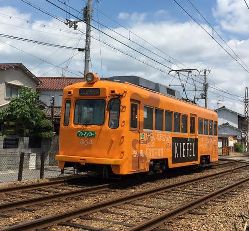

In [6]:
img = PIL.Image.open("train.jpg")
img.resize(np.array(img.size)//2)

Original image set train.jpg
Style image set images/mikakostyle2.jpg

0  42212.80469  min-max  -0.0712582693 - 0.1409906447


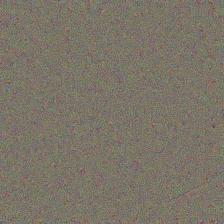

0123456789
10  20359.32227  min-max  -0.2324363738 - 0.1931682825


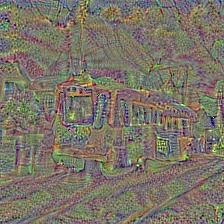

0123456789
20  12281.81055  min-max  -0.1681909859 - 0.1188274026


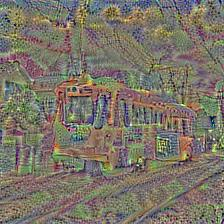

0123456789
30  10277.27734  min-max  -0.1694591492 - 0.1159958839


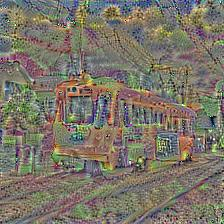

0123456789
40  9307.82617  min-max  -0.0794150010 - 0.1004886031


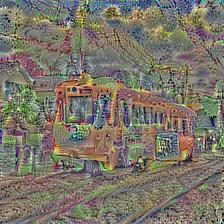

0123456789
50  7941.79443  min-max  -0.0970304310 - 0.0775646791


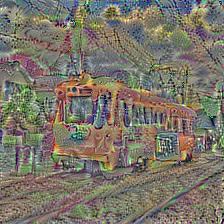

0123456789
60  7595.89062  min-max  -0.1137547046 - 0.0828102604


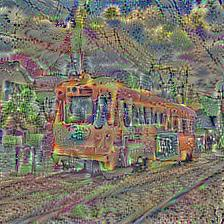

0123456789
70  6934.76270  min-max  -0.0616423450 - 0.0647206828


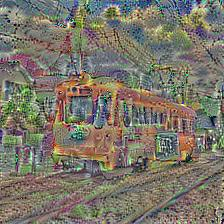

0123456789
80  7099.95996  min-max  -0.0708383247 - 0.1162870452


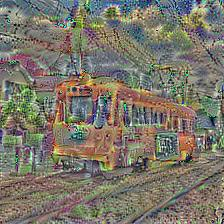

0123456789
90  7118.06543  min-max  -0.0740085617 - 0.0933412090


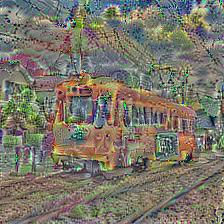

0123456789
100  6277.99316  min-max  -0.0664831325 - 0.0591796972


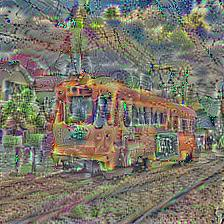

0123456789
110  6423.22949  min-max  -0.0697122216 - 0.0696792603


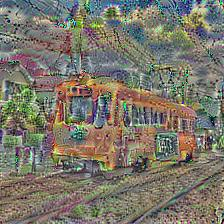

0123456789
120  6304.04443  min-max  -0.0645215884 - 0.0799998716


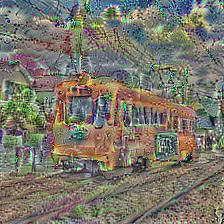

0123456789
130  5920.28125  min-max  -0.0532970950 - 0.0607870556


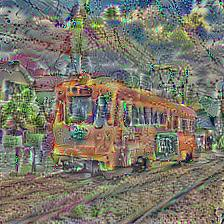

0123456789
140  5891.01318  min-max  -0.0725713074 - 0.1072446927


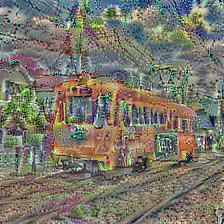

0123456789
150  5825.61182  min-max  -0.0460348837 - 0.0584385917


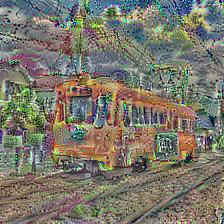

0123456789
160  5551.79688  min-max  -0.0442234799 - 0.0496512279


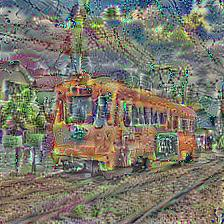

0123456789
170  5460.63867  min-max  -0.0509680733 - 0.0549722910


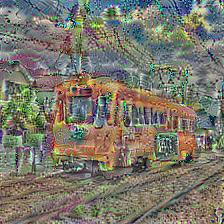

0123456789
180  5695.04297  min-max  -0.0723340064 - 0.0595056713


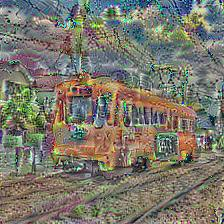

0123456789
190  5424.96387  min-max  -0.0578997694 - 0.0471011624


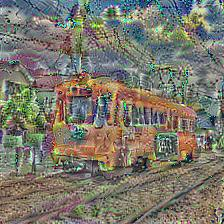

0123456789
200  5300.89404  min-max  -0.0593795627 - 0.0599023104


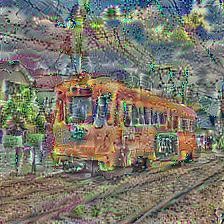

0123456789
210  5390.72266  min-max  -0.0547010079 - 0.0791476667


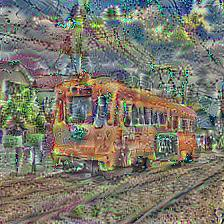

0123456789
220  5324.42871  min-max  -0.0702072531 - 0.0747398287


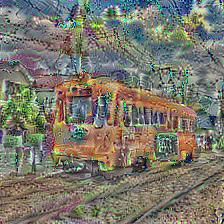

0123456789
230  5136.37793  min-max  -0.0409331396 - 0.0365689322


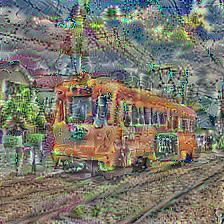

0123456789
240  5130.29736  min-max  -0.0896648094 - 0.0740024671


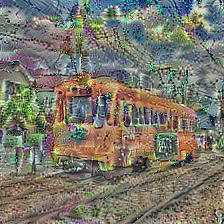

0123456789
250  5084.43359  min-max  -0.0522570238 - 0.0432967469


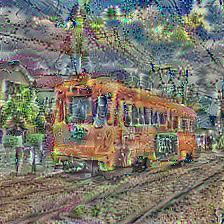

0123456789
260  4996.71094  min-max  -0.0479544736 - 0.0435089804


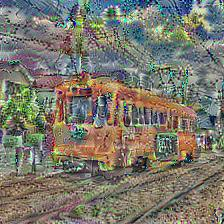

0123456789
270  5342.59766  min-max  -0.0621865802 - 0.0612879172


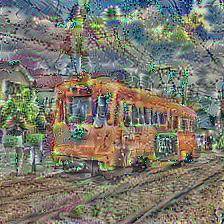

0123456789
280  4932.45361  min-max  -0.0411583707 - 0.0377256423


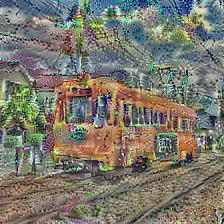

0123456789
290  5092.56152  min-max  -0.0518433824 - 0.0530420281


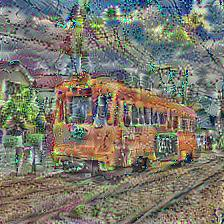

0123456789
300  4932.42480  min-max  -0.0456451401 - 0.0402135365


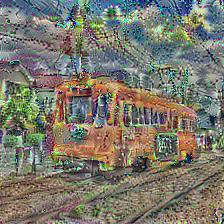

0123456789
310  4831.01074  min-max  -0.0534732267 - 0.0402073897


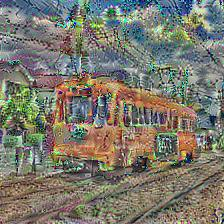

0123456789
320  5178.43945  min-max  -0.0455964953 - 0.0709663704


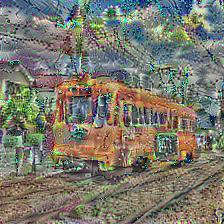

0123456789
330  4858.03271  min-max  -0.0653475225 - 0.0504029803


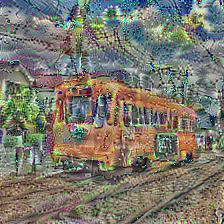

0123456789
340  4940.33203  min-max  -0.0561197288 - 0.0679129064


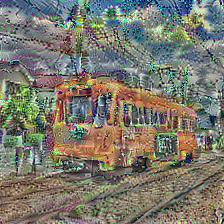

0123456789
350  4730.76758  min-max  -0.0290612858 - 0.0256666094


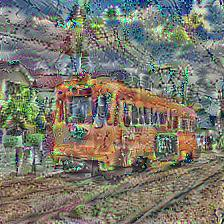

0123456789
360  5024.24805  min-max  -0.0510878339 - 0.0620274283


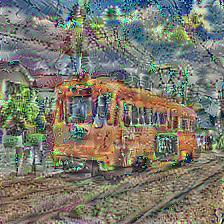

0123456789
370  4792.04346  min-max  -0.0405961163 - 0.0373902060


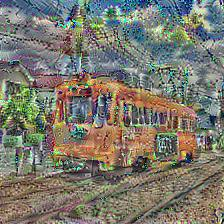

0123456789
380  4726.50195  min-max  -0.0403380096 - 0.0384063721


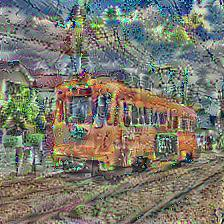

0123456789
390  4685.35742  min-max  -0.0337945968 - 0.0383552797


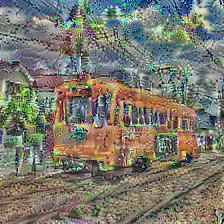

0123456789
400  4959.47314  min-max  -0.0610514134 - 0.0757354796


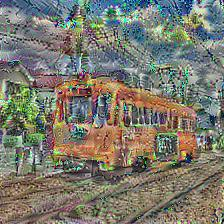

0123456789
410  4718.98633  min-max  -0.0475778580 - 0.0423405953


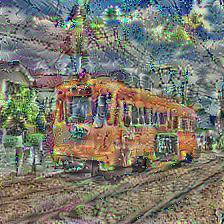

0123456789
420  4726.16699  min-max  -0.0391896926 - 0.0376925468


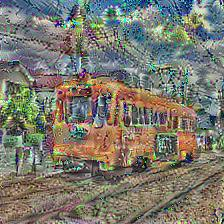

0123456789
430  4701.75977  min-max  -0.0519072227 - 0.0430613644


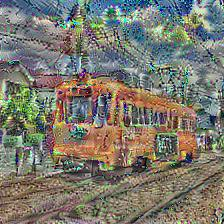

0123456789
440  4641.02246  min-max  -0.0484600142 - 0.0478029773


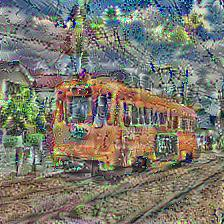

0123456789
450  4645.11426  min-max  -0.0386710800 - 0.0381175764


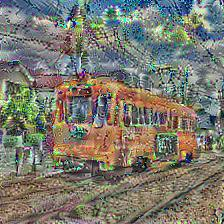

0123456789
460  4706.02490  min-max  -0.0507452823 - 0.0517428257


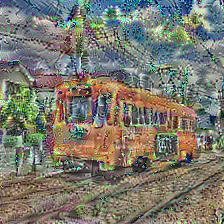

0123456789
470  4567.81592  min-max  -0.0288134739 - 0.0323166326


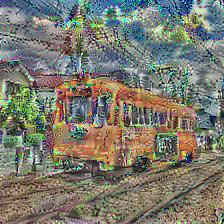

0123456789
480  4745.02246  min-max  -0.0444542281 - 0.0518333651


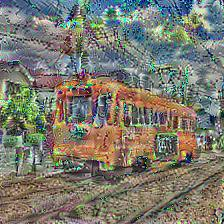

0123456789
490  4651.82031  min-max  -0.0475129709 - 0.0484251231


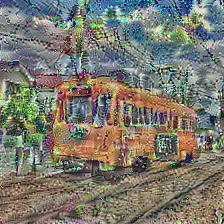

0123456789

In [8]:
lr = np.float32(200.0) # 学習係数
rr = np.float32(0.5)
generate(nn,"train.jpg","images/mikakostyle2.jpg",itr=500)